In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Import our AlphaVantage system
import sys
sys.path.append('../src')  # Adjust path as needed
from alphavantage_system import AlphaVantageFactorSystem

In [ ]:
API_KEY = "2J6C7VY2IH3N90L7"  

# Initialize system
av_system = AlphaVantageFactorSystem(
    api_key=API_KEY,
    data_dir='../data/av_data',
    db_path='../data/av_cache.db'
)

In [ ]:
# Define test universe
test_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 
                'JPM', 'BAC', 'XOM', 'JNJ', 'WMT']

print(f"Downloading data for {len(test_tickers)} stocks...")
print("This will take about 8 seconds with rate limiting...")

# Download (only runs if not cached)
av_system.download_universe_data(test_tickers)

In [ ]:
# Load price data
price_data = av_system.load_price_data(test_tickers)

print(f"Data shape: {price_data.shape}")
print(f"Date range: {price_data.index[0].strftime('%Y-%m-%d')} to {price_data.index[-1].strftime('%Y-%m-%d')}")
print(f"\nMissing data by ticker:")
print(price_data.isnull().sum())

# %%
# Visualize price performance
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Normalized prices
normalized_prices = price_data / price_data.iloc[0]
normalized_prices.plot(ax=axes[0], alpha=0.8)
axes[0].set_title('Normalized Price Performance', fontsize=14)
axes[0].set_ylabel('Normalized Price')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Rolling volatility
returns = price_data.pct_change()
rolling_vol = returns.rolling(30).std() * np.sqrt(252)
rolling_vol.plot(ax=axes[1], alpha=0.8)
axes[1].set_title('30-Day Rolling Volatility (Annualized)', fontsize=14)
axes[1].set_ylabel('Volatility')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate all factors
factors = av_system.calculate_factors(price_data)

# Display available factors
print("Available factor categories:")
for category, factor_data in factors.items():
    print(f"\n{category.upper()}:")
    if isinstance(factor_data, pd.DataFrame):
        print(f"  Shape: {factor_data.shape}")
        print(f"  Factors: {list(factor_data.columns)[:5]}...")

In [ ]:
# %%
# Let's create a proper factor snapshot
factor_snapshot = pd.DataFrame(index=price_data.columns)

# Check the structure first
print("Checking factor structure...")
for category, factor_dict in factors.items():
    print(f"\n{category}: {type(factor_dict)}")
    if isinstance(factor_dict, dict):
        for factor_name, factor_values in factor_dict.items():
            print(f"  {factor_name}: {type(factor_values)}")
            
            # If it's a Series, take the last value
            if isinstance(factor_values, pd.Series):
                factor_snapshot[f'{category}_{factor_name}'] = factor_values
            
            # If it's a DataFrame, take the last row
            elif isinstance(factor_values, pd.DataFrame):
                # Get the latest non-null value for each column
                latest_values = factor_values.iloc[-30:].bfill().iloc[-1]
                factor_snapshot[f'{category}_{factor_name}'] = latest_values

print(f"\nFactor snapshot shape: {factor_snapshot.shape}")
factor_snapshot.head()

In [ ]:
# Momentum factor analysis
momentum_factors = [col for col in factor_snapshot.columns if 'mom_' in col]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Factor values
factor_snapshot[momentum_factors].plot(kind='bar', ax=axes[0])
axes[0].set_title('Momentum Factors by Stock')
axes[0].set_ylabel('Factor Value')
axes[0].legend(bbox_to_anchor=(1.05, 1))

# Factor correlations
mom_corr = factor_snapshot[momentum_factors].corr()
sns.heatmap(mom_corr, annot=True, cmap='RdBu', center=0, ax=axes[1])
axes[1].set_title('Momentum Factor Correlations')

plt.tight_layout()
plt.show()

# Top/Bottom stocks by 60-day momentum
mom_60d = factor_snapshot['momentum_mom_60d'].sort_values(ascending=False)

print("TOP 5 MOMENTUM STOCKS (60-day)")
print(mom_60d.head().to_frame('60d_momentum'))
print("\nBOTTOM 5 MOMENTUM STOCKS (60-day)")
print(mom_60d.tail().to_frame('60d_momentum'))

In [ ]:
def fixed_momentum_backtest(prices, returns, lookback=60, rebalance_days=20):
    """
    FIXED version of your momentum strategy backtest
    
    The original issue was with pandas chained assignment in position setting.
    This version uses proper .loc indexing to fix the problem.
    """
    print(f"=== FIXED MOMENTUM BACKTEST ===")
    print(f"Data: {prices.shape[0]} days x {prices.shape[1]} stocks")
    print(f"Parameters: {lookback}d lookback, rebalance every {rebalance_days}d")
    
    # Calculate momentum signal
    momentum = prices.pct_change(lookback)
    
    # Initialize positions DataFrame with proper dtypes
    positions = pd.DataFrame(0.0, index=returns.index, columns=returns.columns, dtype=float)
    
    rebalance_count = 0
    
    # Rebalance every N days
    for i in range(lookback, len(returns), rebalance_days):
        # Get current momentum
        current_mom = momentum.iloc[i]
        
        # Select top 30% of stocks (remove NaN values first)
        valid_momentum = current_mom.dropna()
        if len(valid_momentum) == 0:
            continue
            
        n_stocks = max(1, int(len(valid_momentum) * 0.3))
        top_stocks = valid_momentum.nlargest(n_stocks).index
        
        # Calculate position period
        end_idx = min(i + rebalance_days, len(positions))
        
        # FIXED: Use proper .loc indexing instead of chained assignment
        # Clear all positions for this period first
        positions.iloc[i:end_idx] = 0.0
        
        # Set equal weight positions using .loc
        weight = 1.0 / len(top_stocks)
        for stock in top_stocks:
            if stock in positions.columns:
                positions.loc[positions.index[i:end_idx], stock] = weight
        
        rebalance_count += 1
        
        if rebalance_count <= 5:  # Show first 5 rebalances
            print(f"  Rebalance {rebalance_count} on {returns.index[i].date()}: {list(top_stocks)} (weight: {weight:.3f})")
    
    print(f"Total rebalances: {rebalance_count}")
    
    # Calculate strategy returns with proper look-ahead bias prevention
    strategy_returns = (positions.shift(1) * returns).sum(axis=1)
    strategy_returns = strategy_returns.dropna()
    
    # Verify positions are actually set
    total_positions = positions.sum(axis=1)
    non_zero_positions = (total_positions > 0.01).sum()
    
    print(f"Position verification:")
    print(f"  Days with positions: {non_zero_positions} / {len(positions)}")
    print(f"  Average position sum: {total_positions.mean():.3f}")
    print(f"  Position sum range: {total_positions.min():.3f} to {total_positions.max():.3f}")
    
    print(f"Strategy returns:")
    print(f"  Shape: {strategy_returns.shape}")
    print(f"  Non-zero returns: {(strategy_returns != 0).sum()}")
    print(f"  Mean daily return: {strategy_returns.mean():.6f}")
    print(f"  Std daily return: {strategy_returns.std():.6f}")
    print(f"  Total return: {(1 + strategy_returns).prod() - 1:.4f} ({(1 + strategy_returns).prod() - 1:.2%})")
    
    return strategy_returns, positions

# Run backtest
strat_returns, positions = fixed_momentum_backtest(price_data, returns)

In [ ]:
# Performance analysis
cumulative_strat = (1 + strat_returns).cumprod()
cumulative_bench = (1 + returns.mean(axis=1)).cumprod()  # Equal weight benchmark

# Calculate metrics
def calculate_metrics(returns):
    metrics = {
        'Annual Return': returns.mean() * 252,
        'Annual Volatility': returns.std() * np.sqrt(252),
        'Sharpe Ratio': (returns.mean() * 252) / (returns.std() * np.sqrt(252)),
        'Max Drawdown': (returns.cumsum().cummax() - returns.cumsum()).max(),
        'Win Rate': (returns > 0).mean()
    }
    return pd.Series(metrics)

# Compare strategy vs benchmark
comparison = pd.DataFrame({
    'Momentum Strategy': calculate_metrics(strat_returns),
    'Equal Weight Benchmark': calculate_metrics(returns.mean(axis=1))
})

print("PERFORMANCE COMPARISON")
print(comparison.round(3))

In [ ]:
# Plot cumulative returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Cumulative returns
ax1.plot(cumulative_strat.index, cumulative_strat.values, label='Momentum Strategy', linewidth=2)
ax1.plot(cumulative_bench.index, cumulative_bench.values, label='Equal Weight Benchmark', linewidth=2)
ax1.set_title('Cumulative Returns Comparison', fontsize=14)
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rolling Sharpe ratio (60-day)
rolling_sharpe_strat = (strat_returns.rolling(60).mean() * 252) / (strat_returns.rolling(60).std() * np.sqrt(252))
rolling_sharpe_bench = (returns.mean(axis=1).rolling(60).mean() * 252) / (returns.mean(axis=1).rolling(60).std() * np.sqrt(252))

ax2.plot(rolling_sharpe_strat.index, rolling_sharpe_strat.values, label='Momentum Strategy', linewidth=2)
ax2.plot(rolling_sharpe_bench.index, rolling_sharpe_bench.values, label='Benchmark', linewidth=2)
ax2.set_title('Rolling 60-Day Sharpe Ratio', fontsize=14)
ax2.set_ylabel('Sharpe Ratio')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyze momentum vs volatility relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
ax1 = axes[0]
scatter = ax1.scatter(
    factor_snapshot['volatility_vol_60d'], 
    factor_snapshot['momentum_mom_60d'],
    s=100, alpha=0.6, c=factor_snapshot['momentum_mom_60d'],
    cmap='RdYlGn'
)
ax1.set_xlabel('60-Day Volatility')
ax1.set_ylabel('60-Day Momentum')
ax1.set_title('Momentum vs Volatility')

# Add stock labels
for idx, txt in enumerate(factor_snapshot.index):
    ax1.annotate(txt, (factor_snapshot['volatility_vol_60d'].iloc[idx], 
                       factor_snapshot['momentum_mom_60d'].iloc[idx]),
                fontsize=8, alpha=0.7)

# Risk-adjusted momentum
factor_snapshot['risk_adj_momentum'] = (
    factor_snapshot['momentum_mom_60d'] / 
    factor_snapshot['volatility_vol_60d']
)

axes[1].bar(factor_snapshot.index, factor_snapshot['risk_adj_momentum'])
axes[1].set_title('Risk-Adjusted Momentum (Mom/Vol)')
axes[1].set_ylabel('Risk-Adjusted Momentum')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Once test works, expand to S&P 500
sp500_tickers = av_system.get_universe_tickers('sp500')

# This will take ~7 minutes for 500 stocks
# Run it once, then data is cached!
av_system.download_universe_data(sp500_tickers[:100])  # Start with first 100

# Load and calculate factors for the larger universe
sp500_data = av_system.load_price_data(sp500_tickers[:100])
sp500_factors = av_system.calculate_factors(sp500_data)

In [ ]:
# Combine all factors into one DataFrame
all_factors = pd.DataFrame()
for category, factor_dict in sp500_factors.items():
    for factor_name, factor_data in factor_dict.items():
        if isinstance(factor_data, pd.Series):
            all_factors[factor_name] = factor_data
        elif isinstance(factor_data, pd.DataFrame):
            all_factors[factor_name] = factor_data.iloc[-1]  # Latest values

# Rank stocks by momentum
all_factors['mom_60d_rank'] = all_factors['mom_60d'].rank(pct=True)

# Create quintile portfolios
all_factors['momentum_quintile'] = pd.qcut(
    all_factors['mom_60d'].dropna(), 
    q=5, 
    labels=['Q1_Low', 'Q2', 'Q3', 'Q4', 'Q5_High']
)

# Get top momentum stocks
top_momentum = all_factors.nlargest(10, 'mom_60d')
print("\nTop 10 Momentum Stocks:")
print(top_momentum[['mom_60d', 'vol_20d']])

In [ ]:
# Simple momentum strategy backtest
def backtest_momentum_strategy(price_data, lookback=60, holding_period=20):
    """
    Simple momentum strategy:
    - Rank by past 60-day returns
    - Hold top 20% for 20 days
    - Rebalance monthly
    """
    returns = price_data.pct_change()
    
    # Calculate rolling momentum
    momentum = price_data.pct_change(lookback)
    
    # Strategy returns
    strategy_returns = []
    
    # Rebalance monthly
    for i in range(lookback, len(price_data), holding_period):
        # Get momentum at rebalance date
        current_momentum = momentum.iloc[i]
        
        # Select top 20% of stocks
        top_quintile = current_momentum.nlargest(int(len(current_momentum) * 0.2))
        selected_stocks = top_quintile.index
        
        # Calculate equal-weighted returns for holding period
        period_end = min(i + holding_period, len(price_data))
        period_returns = returns.iloc[i:period_end][selected_stocks].mean(axis=1)
        strategy_returns.extend(period_returns.values)
    
    # Convert to series
    strategy_returns = pd.Series(
        strategy_returns, 
        index=price_data.index[lookback:lookback+len(strategy_returns)]
    )
    
    # Calculate performance metrics
    annual_return = strategy_returns.mean() * 252
    annual_vol = strategy_returns.std() * np.sqrt(252)
    sharpe_ratio = annual_return / annual_vol
    
    cumulative_returns = (1 + strategy_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    
    print("Momentum Strategy Performance:")
    print(f"Annual Return: {annual_return:.2%}")
    print(f"Annual Volatility: {annual_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    
    return strategy_returns, cumulative_returns

# Run backtest
strategy_returns, cumulative = backtest_momentum_strategy(sp500_data)

# Plot results
plt.figure(figsize=(12, 6))
cumulative.plot()
plt.title('Momentum Strategy Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.show()

In [ ]:
# Create more sophisticated factors
def calculate_advanced_factors(price_data, volume_data=None):
    """Calculate more complex factors"""
    returns = price_data.pct_change()
    
    factors = pd.DataFrame(index=price_data.columns)
    
    # 1. Momentum with volatility scaling
    momentum = price_data.iloc[-1] / price_data.iloc[-60] - 1
    volatility = returns.tail(60).std() * np.sqrt(252)
    factors['risk_adjusted_momentum'] = momentum / volatility
    
    # 2. Mean reversion indicators
    sma_20 = price_data.rolling(20).mean()
    factors['price_to_sma20'] = (price_data.iloc[-1] / sma_20.iloc[-1]) - 1
    
    # 3. Trend strength (R-squared of linear regression)
    from scipy import stats
    for ticker in price_data.columns:
        y = np.log(price_data[ticker].tail(60).dropna())
        if len(y) >= 60:
            x = np.arange(len(y))
            _, _, r_value, _, _ = stats.linregress(x, y)
            factors.loc[ticker, 'trend_strength'] = r_value ** 2
    
    # 4. Volatility regime
    short_vol = returns.tail(20).std()
    long_vol = returns.tail(60).std()
    factors['vol_regime'] = short_vol / long_vol
    
    return factors

# Calculate advanced factors
advanced_factors = calculate_advanced_factors(sp500_data)

In [ ]:
# %%
# Time-series factor calculation and analysis
def calculate_factors_over_time(price_data, lookback_days=252):
    """Calculate factors for each day in the lookback period"""
    
    returns = price_data.pct_change()
    factor_series = {}
    
    # We'll calculate factors for the last N days
    for i in range(lookback_days, len(price_data)):
        date = price_data.index[i]
        
        # Calculate factors as of this date
        current_prices = price_data.iloc[:i+1]
        current_returns = returns.iloc[:i+1]
        
        # Momentum factors
        if len(current_prices) > 60:
            mom_20 = current_prices.iloc[-1] / current_prices.iloc[-20] - 1
            mom_60 = current_prices.iloc[-1] / current_prices.iloc[-60] - 1
            
            if date not in factor_series:
                factor_series[date] = {}
            
            factor_series[date]['mom_20d'] = mom_20
            factor_series[date]['mom_60d'] = mom_60
            
            # Volatility
            vol_20 = current_returns.iloc[-20:].std() * np.sqrt(252)
            factor_series[date]['vol_20d'] = vol_20
    
    return factor_series

# Calculate time-series factors (this will take a moment)
print("Calculating time-series factors...")
ts_factors = calculate_factors_over_time(price_data, lookback_days=100)
print(f"Calculated factors for {len(ts_factors)} days")

# %%
# Now analyze with proper forward returns
def analyze_factor_with_forward_returns(price_data, ts_factors, factor_name, forward_days=20):
    """Analyze factor predictive power with proper forward returns"""
    
    all_correlations = []
    
    for date, factors in ts_factors.items():
        if factor_name not in factors:
            continue
            
        # Find the date index
        date_idx = price_data.index.get_loc(date)
        
        # Skip if we don't have enough forward data
        if date_idx + forward_days >= len(price_data):
            continue
        
        # Calculate forward returns
        forward_returns = (
            price_data.iloc[date_idx + forward_days] / 
            price_data.iloc[date_idx] - 1
        )
        
        # Get factor values for this date
        factor_values = factors[factor_name]
        
        # Calculate correlation for this date
        common_stocks = factor_values.index.intersection(forward_returns.index)
        if len(common_stocks) > 5:
            corr = factor_values[common_stocks].corr(forward_returns[common_stocks])
            all_correlations.append({
                'date': date,
                'correlation': corr,
                'n_stocks': len(common_stocks)
            })
    
    # Convert to DataFrame
    corr_df = pd.DataFrame(all_correlations)
    
    if len(corr_df) > 0:
        print(f"\nFactor: {factor_name}")
        print(f"Average IC: {corr_df['correlation'].mean():.3f}")
        print(f"IC Std Dev: {corr_df['correlation'].std():.3f}")
        print(f"IC Sharpe: {corr_df['correlation'].mean() / corr_df['correlation'].std():.3f}")
        
        # Plot IC over time
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 1, 1)
        plt.plot(corr_df['date'], corr_df['correlation'])
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.axhline(y=corr_df['correlation'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean IC: {corr_df["correlation"].mean():.3f}')
        plt.title(f'Information Coefficient Over Time: {factor_name}')
        plt.ylabel('IC')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.hist(corr_df['correlation'], bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        plt.axvline(x=corr_df['correlation'].mean(), color='red', linestyle='--', alpha=0.5)
        plt.title('IC Distribution')
        plt.xlabel('IC')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        return corr_df
    else:
        print(f"No data available for {factor_name}")
        return None

# Analyze time-series factors
if ts_factors:
    ic_results = {}
    for factor_name in ['mom_20d', 'mom_60d', 'vol_20d']:
        ic_df = analyze_factor_with_forward_returns(price_data, ts_factors, factor_name)
        if ic_df is not None:
            ic_results[factor_name] = ic_df




In [ ]:
exec(open('../check_cache.py').read())

📋 Resolving 1 symbols (ETF expansion: True)...
🔍 Processing symbol 1/1: SPY
📈 Detected ETF SPY, fetching holdings...
✅ ETF SPY expanded to 503 valid constituents (filtered from 504 total)
🎉 Symbol resolution complete: 503 unique tickers from 1 input symbols
🚀 Starting factor model fitting with method: fundamental
📈 Step 1/3: Loading price data for 503 tickers...
💰 Loading price data for 503 tickers...
📊 Processing ticker 1/503: A
📊 Processing ticker 50/503: AZO
📊 Processing ticker 100/503: CNC
📊 Processing ticker 150/503: EA
📊 Processing ticker 200/503: GEHC
📊 Processing ticker 250/503: ISRG
📊 Processing ticker 300/503: MCHP
📊 Processing ticker 350/503: O
📊 Processing ticker 400/503: ROP
📊 Processing ticker 450/503: TSLA
📊 Processing ticker 500/503: YUM
🔗 Concatenating price data...
✅ Price data loaded: 6650 days x 503 tickers
✅ Price data loaded: 6650 days x 503 tickers
📊 Step 2/3: Calculating log returns...
✅ Returns calculated: 6649 days x 503 tickers
🧮 Step 3/3: Fitting fundamental

⚠️ Failed to compute factors for 62 dates
🎉 Factor model fitting complete!
📊 Factors shape: (6587, 199)
📋 Exposures shape: (503, 199)


/Users/kevinturner/Documents/Code/equity-factors/src/factor_performance_table.py:93: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


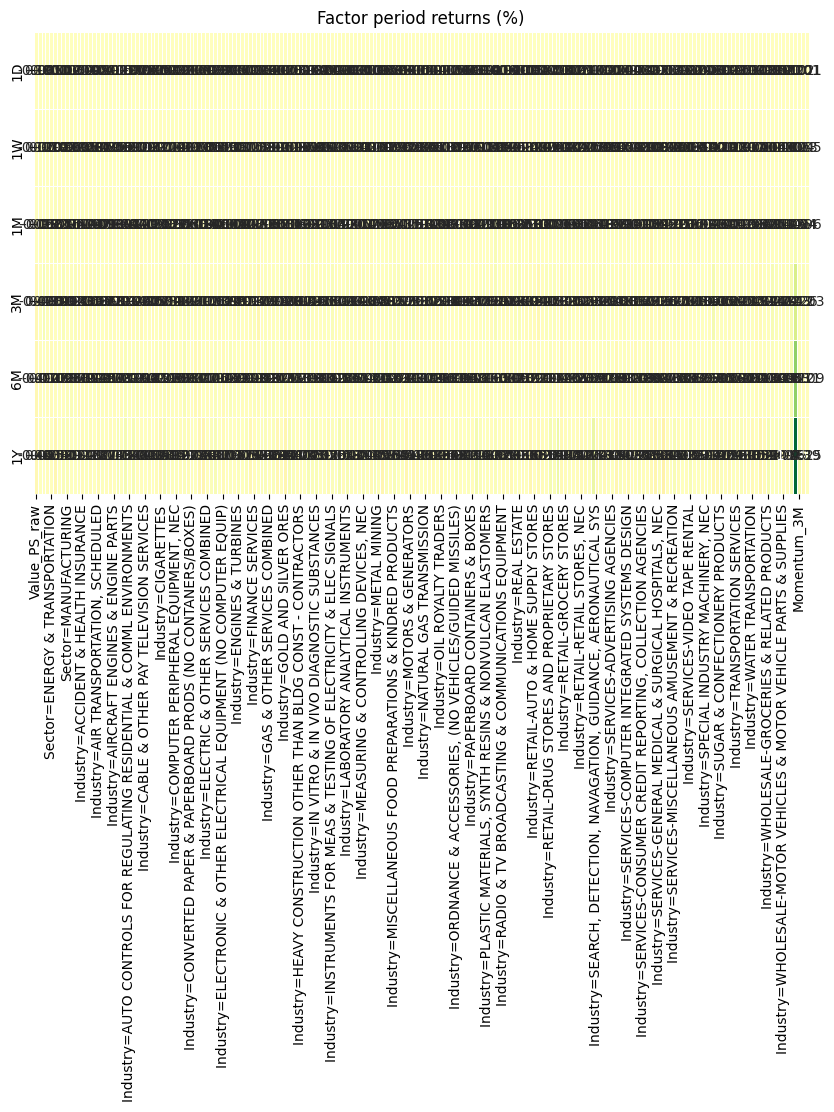

{'Value_PS_raw': 'A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE. Negative: A, AAPL, ABBV, ABNB, ABT, ACGL, ACN, ADBE. This factor highlights stocks that maintain a steady performance across different metrics.'}


In [1]:
from research import FactorResearchSystem
from factor_performance_table import generate_report

API_KEY = "2J6C7VY2IH3N90L7"

# just give the ETF!
frs = FactorResearchSystem(API_KEY, universe=["SPY"], factor_method="fundamental")
frs.fit_factors()

# target 10 % vol factors
f = frs.get_factor_returns(vol_target=0.10)
generate_report(f)

# optional: catchy names
print(frs.name_factors())
